In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

hyperparam_tunning = False

In [2]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [3]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))

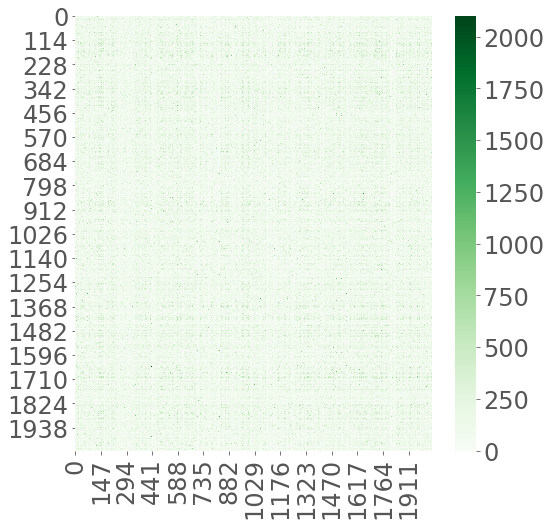

In [4]:
features_correlation(features_shared)

In [5]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
features_shared = sel.fit_transform(features_shared)
features_only_2c9 = sel.transform(features_only_2c9)
features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold=(threshold * (1 - threshold)))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

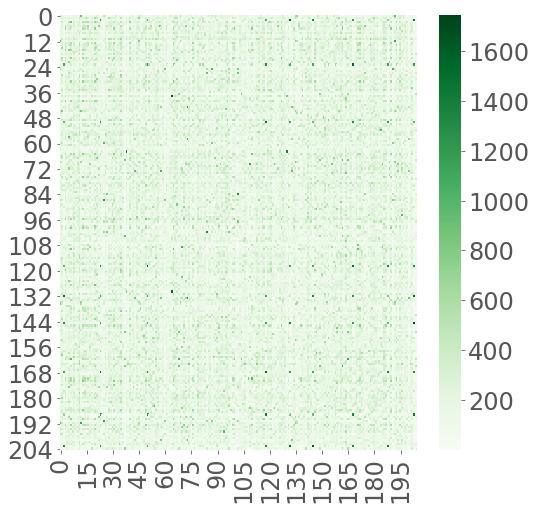

In [6]:
features_correlation(shared_reduced)

We will use the same train/test split with all tests

In [7]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)

We try selecting the top features, moving the percentile value

In [8]:
hidden_layers = 4
neurons = 130
dropout = 0.2
lr = 0.1
opt  = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.0010000
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 103 features
NER: 0.738, Sensitivity or recall: 0.675, Specificity: 0.801, Precision: 0.616, Correctly calssified: 0.761, MCC: 0.466
Testing
NER: 0.676, Sensitivity or recall: 0.570, Specificity: 0.781, Precision: 0.596, Correctly calssified: 0.705, MCC: 0.355
Validation set with 10 percentile, 205 features
NER: 0.740, Sensitivity or recall: 0.666, Specificity: 0.815, Precision: 0.630, Correctly calssified: 0.767, MCC: 0.474
Testing
NER: 0.694, Sensitivity or recall: 0.602, Specificity: 0.786, Precision: 0.614, Correctly calssified: 0.720, MCC: 0.390
Validation set with 15 percentile, 307 features
NER: 0.712, Sensitivity or recall: 0.530, Specificity: 0.894, Precision: 0.704, Correctly calssified: 0.777, MCC: 0.462
Testing
NER: 0.666, Sensitivity or recall: 0.445, Specificity: 0.888, Precision: 0.691, Correctly calssified: 0.728, MCC: 0.378
Validation set with 20 percentile, 409 features
NER: 0.713, Sensitivity or recall: 0.575, Specificity: 0.852, Pre

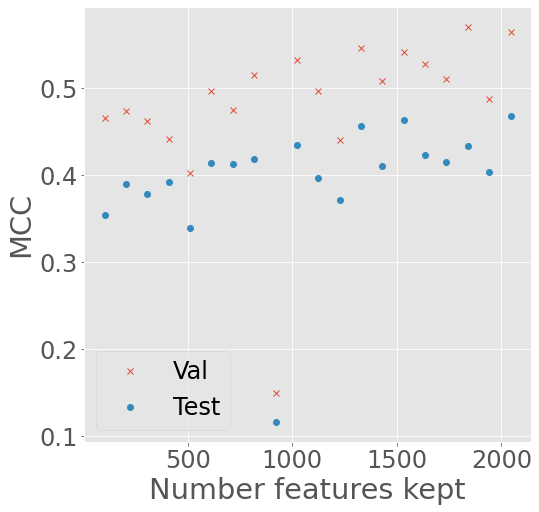

In [9]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
NER: 0.737, Sensitivity or recall: 0.620, Specificity: 0.854, Precision: 0.668, Correctly calssified: 0.779, MCC: 0.484
Testing
NER: 0.696, Sensitivity or recall: 0.559, Specificity: 0.833, Precision: 0.654, Correctly calssified: 0.734, MCC: 0.408
Validation set with 10 percentile, 205 features
NER: 0.760, Sensitivity or recall: 0.662, Specificity: 0.859, Precision: 0.689, Correctly calssified: 0.795, MCC: 0.526
Testing
NER: 0.700, Sensitivity or recall: 0.571, Specificity: 0.829, Precision: 0.654, Correctly calssified: 0.736, MCC: 0.414
Validation set with 15 percentile, 307 features
NER: 0.764, Sensitivity or recall: 0.671, Specificity: 0.857, Precision: 0.690, Correctly calssified: 0.797, MCC: 0.532
Testing
NER: 0.702, Sensitivity or recall: 0.579, Specificity: 0.825, Precision: 0.651, Correctly calssified: 0.736, MCC: 0.415
Validation set with 20 percentile, 409 features
NER: 0.763, Sensitivity or recall: 0.667, Specificity: 0.858, Pre

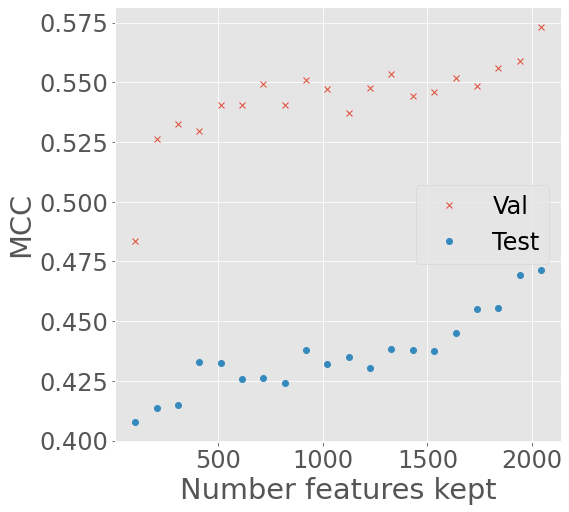

In [10]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
Testing
Validation set with 10 percentile, 205 features
Testing
Validation set with 15 percentile, 307 features
Testing
Validation set with 20 percentile, 409 features
Testing
Validation set with 25 percentile, 511 features
Testing
Validation set with 30 percentile, 613 features
Testing
Validation set with 35 percentile, 716 features
Testing
Validation set with 40 percentile, 818 features
Testing
Validation set with 45 percentile, 920 features
Testing
Validation set with 50 percentile, 1022 features
Testing
Validation set with 55 percentile, 1124 features
Testing
Validation set with 60 percentile, 1226 features
Testing
Validation set with 65 percentile, 1328 features
Testing
Validation set with 70 percentile, 1431 features
Testing
Validation set with 75 percentile, 1533 features
Testing
Validation set with 80 percentile, 1635 features
Testing
Validation set with 85 percentile, 1737 features
Testing
Validation set with 90 percentile, 1839 f

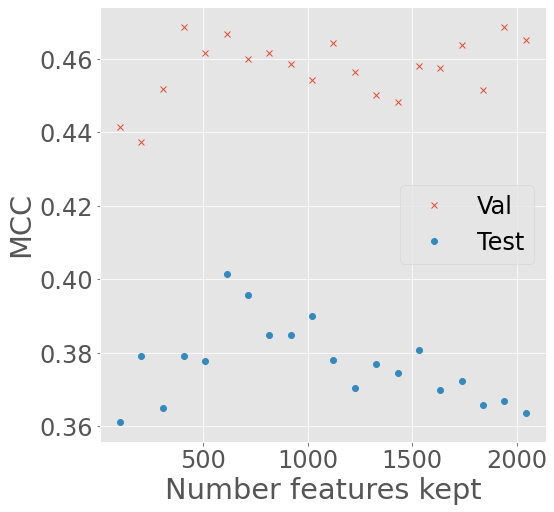

In [11]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 103 features
Testing
Validation set with 10 percentile, 205 features
Testing
Validation set with 15 percentile, 307 features
Testing
Validation set with 20 percentile, 409 features
Testing
Validation set with 25 percentile, 511 features
Testing
Validation set with 30 percentile, 613 features
Testing
Validation set with 35 percentile, 716 features
Testing
Validation set with 40 percentile, 818 features
Testing
Validation set with 45 percentile, 920 features
Testing
Validation set with 50 percentile, 1022 features
Testing
Validation set with 55 percentile, 1124 features
Testing
Validation set with 60 percentile, 1226 features
Testing
Validation set with 65 percentile, 1328 features
Testing
Validation set with 70 percentile, 1431 features
Testing
Validation set with 75 percentile, 1533 features
Testing
Validation set with 80 percentile, 1635 features
Testing
Validation set with 85 percentile, 1737 features
Testing
Validation set with 90 percentile, 1839 f

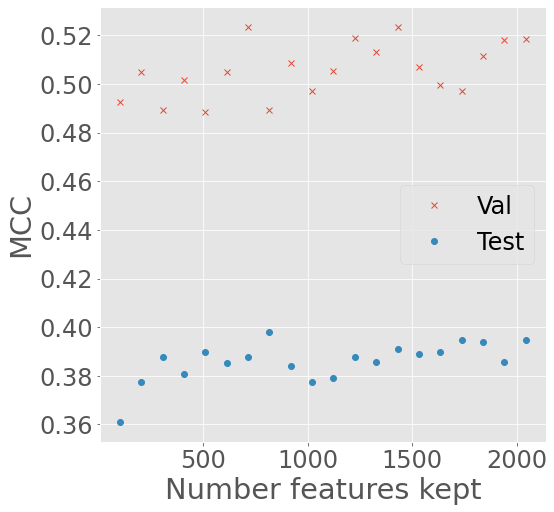

In [12]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    N_BITS = train_data_trans.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [13]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        sel.fit(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced_trans = sel.transform(features_only_2c9)
    train_data_trans = sel.transform(train_data)
    val_data_trans = sel.transform(val_data)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 2044 features
NER: 0.768, Sensitivity or recall: 0.674, Specificity: 0.862, Precision: 0.699, Correctly calssified: 0.802, MCC: 0.541
Testing
NER: 0.722, Sensitivity or recall: 0.601, Specificity: 0.843, Precision: 0.684, Correctly calssified: 0.756, MCC: 0.459
Validation set with 0.2 percentile, 2013 features
NER: 0.789, Sensitivity or recall: 0.794, Specificity: 0.785, Precision: 0.636, Correctly calssified: 0.788, MCC: 0.551
Testing
NER: 0.734, Sensitivity or recall: 0.714, Specificity: 0.755, Precision: 0.622, Correctly calssified: 0.740, MCC: 0.457
Validation set with 0.30000000000000004 percentile, 1482 features
NER: 0.744, Sensitivity or recall: 0.620, Specificity: 0.869, Precision: 0.692, Correctly calssified: 0.789, MCC: 0.504
Testing
NER: 0.703, Sensitivity or recall: 0.552, Specificity: 0.853, Precision: 0.680, Correctly calssified: 0.744, MCC: 0.428
Validation set with 0.4 percentile, 552 features
NER: 0.780, Sensitivity or recall: 0.764,

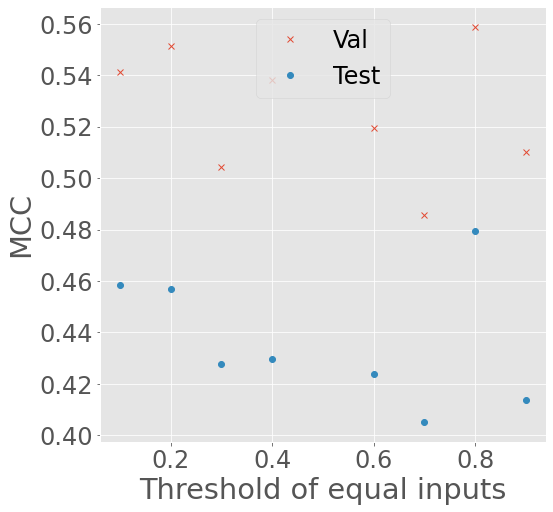

In [14]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [15]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    sel.fit(train_data_trans)

    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data_trans, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 103 features
NER: 0.764, Sensitivity or recall: 0.749, Specificity: 0.779, Precision: 0.616, Correctly calssified: 0.769, MCC: 0.506
Testing
NER: 0.680, Sensitivity or recall: 0.637, Specificity: 0.722, Precision: 0.565, Correctly calssified: 0.691, MCC: 0.351
Validation set with 10 percentile, 205 features
NER: 0.674, Sensitivity or recall: 0.413, Specificity: 0.934, Precision: 0.749, Correctly calssified: 0.767, MCC: 0.425
Testing
NER: 0.621, Sensitivity or recall: 0.329, Specificity: 0.913, Precision: 0.682, Correctly calssified: 0.702, MCC: 0.306
Validation set with 15 percentile, 307 features
NER: 0.685, Sensitivity or recall: 0.476, Specificity: 0.895, Precision: 0.682, Correctly calssified: 0.760, MCC: 0.415
Testing
NER: 0.655, Sensitivity or recall: 0.413, Specificity: 0.896, Precision: 0.693, Correctly calssified: 0.722, MCC: 0.362
Validation set with 20 percentile, 409 features
NER: 0.708, Sensitivity or recall: 0.544, Specificity: 0.872, Pre

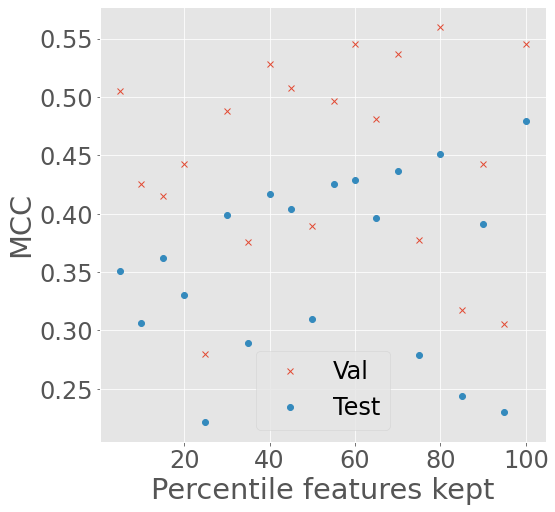

In [16]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 103 features
NER: 0.737, Sensitivity or recall: 0.620, Specificity: 0.854, Precision: 0.668, Correctly calssified: 0.779, MCC: 0.484
Testing
NER: 0.696, Sensitivity or recall: 0.559, Specificity: 0.833, Precision: 0.654, Correctly calssified: 0.734, MCC: 0.408
Validation set with 10 percentile, 205 features
NER: 0.760, Sensitivity or recall: 0.662, Specificity: 0.859, Precision: 0.689, Correctly calssified: 0.795, MCC: 0.526
Testing
NER: 0.700, Sensitivity or recall: 0.571, Specificity: 0.829, Precision: 0.654, Correctly calssified: 0.736, MCC: 0.414
Validation set with 15 percentile, 307 features
NER: 0.764, Sensitivity or recall: 0.671, Specificity: 0.857, Precision: 0.690, Correctly calssified: 0.797, MCC: 0.532
Testing
NER: 0.702, Sensitivity or recall: 0.579, Specificity: 0.825, Precision: 0.651, Correctly calssified: 0.736, MCC: 0.415
Validation set with 20 percentile, 409 features
NER: 0.763, Sensitivity or recall: 0.667, Specificity: 0.858, Pre

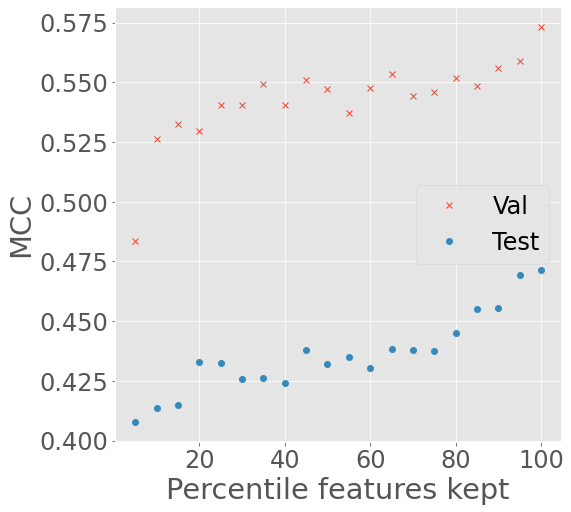

In [17]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    feat_select.fit(features_shared, labels_2c9)
    train_data_trans = feat_select.transform(train_data)
    val_data_trans = feat_select.transform(val_data)
    only_2c9_reduced_trans = feat_select.transform(features_only_2c9)
    sel.fit(train_data_trans)

    train_data_trans = sel.transform(train_data_trans)
    val_data_trans = sel.transform(val_data_trans)
    only_2c9_reduced_trans = sel.transform(only_2c9_reduced_trans)
    N_BITS = train_data_trans.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data_trans, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data_trans)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced_trans)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [18]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 2044) (2813, 2044) (2994, 2044)
(9420, 205) (2813, 205) (2994, 205)
(9420, 205) (2813, 205) (2994, 205)


In [19]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [20]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(2, 6))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete(list(range(10, 61, 10))))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

os.makedirs("hyperparameters_tunning/morgan_fingerprints_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy')])
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels)
    return results

def run(run_dir, hparams):
      if os.path.exists(run_dir):
        return
      with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar("accuracy", accuracy, step=1)

In [21]:
if hyperparam_tunning:
    session_num = 0
    total_runs = len(HP_NEURONS.domain.values)*len(HP_HIDDEN_LAYERS.domain.values)*len([HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value])*len(HP_OPTIMIZER.domain.values)*len([HP_L2.domain.min_value, HP_L2.domain.max_value])*len(HP_LR.domain.values)
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

In [22]:
%tensorboard --logdir hyperparameters_tunning/morgan_fingerprints_feature_selection/logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 29614), started 2:39:23 ago. (Use '!kill 29614' to kill it.)

In [23]:
hidden_layers = 4
neurons = 40
dropout = 0.2
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.Adam()
L2 = 0.010000

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 12s 53ms/step - loss: 1.2438 - binary_accuracy: 0.7282
Epoch 2/10
221/221 [==============================] - 13s 57ms/step - loss: 0.6767 - binary_accuracy: 0.7892
Epoch 3/10
221/221 [==============================] - 13s 59ms/step - loss: 0.5385 - binary_accuracy: 0.8207
Epoch 4/10
221/221 [==============================] - 11s 49ms/step - loss: 0.4797 - binary_accuracy: 0.8313
Epoch 5/10
221/221 [==============================] - 10s 47ms/step - loss: 0.4299 - binary_accuracy: 0.8444
Epoch 6/10
221/221 [==============================] - 10s 47ms/step - loss: 0.3910 - binary_accuracy: 0.8583
Epoch 7/10
221/221 [==============================] - 13s 58ms/step - loss: 0.3617 - binary_accuracy: 0.8723
Epoch 8/10
221/221 [==============================] - 11s 51ms/step - loss: 0.3316 - binary_accuracy: 0.8803
Epoch 9/10
221/221 [==============================] - 12s 55ms/step - loss: 0.3104 - binary_accuracy: 0.8912
Epoch 10/10
221/221

Try the same NN with another feature selection method

In [24]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [25]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 6ms/step - loss: 0.7034 - binary_accuracy: 0.7120
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5294 - binary_accuracy: 0.7404
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5110 - binary_accuracy: 0.7551
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4972 - binary_accuracy: 0.7670
Epoch 5/10
221/221 [==============================] - 1s 6ms/step - loss: 0.4818 - binary_accuracy: 0.7803
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4673 - binary_accuracy: 0.7938
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4449 - binary_accuracy: 0.8109
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4217 - binary_accuracy: 0.8326
Epoch 9/10
221/221 [==============================] - 1s 5ms/step - loss: 0.3921 - binary_accuracy: 0.8498
Epoch 10/10
221/221 [================

In [26]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9, random_state=42)
N_BITS = train_data.shape[1]

In [27]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 7ms/step - loss: 0.6897 - binary_accuracy: 0.7158
Epoch 2/10
221/221 [==============================] - 1s 6ms/step - loss: 0.5242 - binary_accuracy: 0.7425
Epoch 3/10
221/221 [==============================] - 1s 6ms/step - loss: 0.5109 - binary_accuracy: 0.7527
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4946 - binary_accuracy: 0.7670
Epoch 5/10
221/221 [==============================] - 1s 6ms/step - loss: 0.4799 - binary_accuracy: 0.7823
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4557 - binary_accuracy: 0.8031
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4391 - binary_accuracy: 0.8137
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4139 - binary_accuracy: 0.8340
Epoch 9/10
221/221 [==============================] - 1s 5ms/step - loss: 0.3849 - binary_accuracy: 0.8555
Epoch 10/10
221/221 [================

In [28]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(only_2c9_reduced_comb)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.635, Sensitivity or recall: 0.324, Specificity: 0.946, Precision: 0.740, Correctly calssified: 0.746, MCC: 0.363
  Scores for testing
NER: 0.580, Sensitivity or recall: 0.231, Specificity: 0.929, Precision: 0.649, Correctly calssified: 0.677, MCC: 0.230
Scores using C=0.14384498882876628 for validation
NER: 0.665, Sensitivity or recall: 0.400, Specificity: 0.929, Precision: 0.728, Correctly calssified: 0.759, MCC: 0.404
  Scores for testing
NER: 0.599, Sensitivity or recall: 0.297, Specificity: 0.901, Precision: 0.629, Correctly calssified: 0.683, MCC: 0.253
Scores using C=0.20691380811147897 for validation
NER: 0.688, Sensitivity or recall: 0.462, Specificity: 0.914, Precision: 0.719, Correctly calssified: 0.769, MCC: 0.434
  Scores for testing
NER: 0.617, Sensitivity or recall: 0.348, Specificity: 0.885, Precision: 0.632, Correctly calssified: 0.691, MCC: 0.281
Scores using C=0.29763514416313175 for validation
NER: 0.711, Sensitivity or recall